## Final Hparam Optimisation Research Focussing on Learning Rate, Batch-Size, Stride, $N_{filters}$, Pool Size, Kernel Size, (Front and Back) Trimming

### Key: Cathode = 0, Gate = 1, Tritium = 2 | 1 timestep = 10 ns

## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import awkward as ak
import hist
from hist import Hist, axis
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

## Standardising Plot Settings

In [3]:
# Define standard plot colors and style for consistency
plot_colors = {
    'gate': '#4169E1',        # Royal Blue
    'tritium': '#008080',     # Teal
    'cathode': '#8B008B',     # Dark Magenta
    'general': '#333333',     # Dark Gray
    'training': '#228B22',    # Forest Green
    'test': '#B22222'         # Firebrick Red
}

# Set clean, default matplotlib style with white background
plt.style.use('default')

# Configure figure and font settings
plt.rcParams.update({
    'figure.figsize': [10, 8],
    'figure.facecolor': 'white',
    'figure.edgecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'white',
    
    # Font settings
    'font.size': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 20,
    
    # Grid and spine settings
    'axes.grid': False,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    
    # Line settings
    'lines.linewidth': 2.5,
    'lines.markersize': 8
})

# Define the base directory for saving figures
base_dir = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/'

# Function to create consistent plots with white background
def create_standardized_plot(x, y, xlabel, ylabel, title, label=None, color='#333333', 
                            marker='o', linestyle='-', figsize=(12, 8), 
                            save_path=None, dpi=300):
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    ax.plot(x, y, marker=marker, color=color, linestyle=linestyle, label=label)
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Set background and spine colors
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.5)
    
    # Configure ticks
    ax.tick_params(axis='both', which='major', labelsize=14, colors='#333333', width=1.5)
    
    # Add legend if label is provided
    if label:
        ax.legend(frameon=True, facecolor='white', edgecolor='#CCCCCC')
    
    # Finalize layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
    
    return fig, ax

# Example usage
# x_data = [1, 2, 3, 4, 5]
# y_data = [10, 15, 13, 17, 20]
# fig, ax = create_standardized_plot(
#     x_data, y_data, 
#     xlabel='X Axis', 
#     ylabel='Y Axis', 
#     title='Clean White Background Plot',
#     label='Data Series',
#     color=plot_colors['training']
# )

## Pre-Processing the Data: Initial Padding, Weighting, Normalising, Train/Test Splitting, Optimiser Selection

In [4]:
# Load data from Parquet file and convert to strings
data_path = f'{base_dir}/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path)
print(arr.fields)

# Normalising the Data
def normalise_array(arr):
    min_val = ak.min(arr, axis=-1)
    max_val = ak.max(arr, axis=-1)
    return (arr - min_val) / (max_val - min_val)

# Apply normalization to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

# Print or inspect the results
print(normalised_times)
print(normalised_samples)

# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), mode='constant', constant_values=0) for sub_array in ak.to_list(array)]
        )
    )

print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))

times_lengths = ak.num(arr['times'], axis=1)
max_time_length = ak.max(times_lengths) # returns length of longest time series in dataset
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')


padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))
unnormalised_times = arr['times']
unnormalised_padded_times = np.array(pad_to_max_length(unnormalised_times, max_time_length))

sampling_interval_us = 0.01 # interval between consecutive samples in microseconds (1 timestep : 10 ns)
time_us = [np.arange(len(wave)) * sampling_interval_us for wave in unnormalised_times]
print(time_us[1036]) #TEST: the last element in this row should equal 18.3 µs

print(f"Length After Padding: {len(padded_times[0])}")
print(f"Length After Padding: {len(unnormalised_padded_times[3743])}")

# Applying now to sample data
print(len(arr['samples']))
print(f"Length Before Padding: {len(arr['samples'][0])}")
print("Structure of 'times':", ak.type(arr['samples']))

samples_lengths = ak.num(arr['times'], axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Apply initial padding to standardise the length of all samples
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")

padding_length = 500

# X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

# Add zero-padding on each side of the data (only along the time dimension for 2D data) Then reshape X_train_padded and X_test_padded to 3D
normalised_times_padded = np.pad(padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
unnormalised_times_padded = np.pad(unnormalised_padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
normalised_samples_padded = np.pad(padded_samples, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X = normalised_samples_padded # Now, all samples have had 5 µs of padding added to the front and back

time_steps = normalised_times_padded.shape[1]

# Define constants and extract needed data
bins = 100
electron_size = 58.5
areas = np.array(arr['area'])
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

# Create histograms without plotting
gate_hist = Hist(hist.axis.Regular(bins, 0, max(areas)/electron_size*1.01), label='S2 Gate Area Distribution')
gate_hist.fill(gate_events)

tritium_hist = Hist(hist.axis.Regular(bins, 0, max(areas)/electron_size*1.01), label='S2 Gate Tritium Distribution')
tritium_hist.fill(tritium_events)

cathode_hist = Hist(hist.axis.Regular(bins, 0, max(areas)/electron_size*1.01), label='S2 Gate Cathode Distribution')
cathode_hist.fill(cathode_events)

bin_edges = gate_hist.axes[0].edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Retrieve and adjust counts for each histogram to normalise counts across event types.
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False)
cathode_data = cathode_hist.view(flow=False)

print(gate_counts.sum())
print(tritium_counts.sum())
print(cathode_counts.sum())

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(), cathode_counts.sum()])

# Calculate weights and reweighted data
gate_weights = []
gate_reweighted = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()) if gate_counts[datapoint] != 0 else 0)

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()) if tritium_counts[datapoint] != 0 else 0)

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] != 0 else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if cathode_counts[datapoint] != 0 else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)
cathode_reweighted = np.array(cathode_reweighted)

# Creating the Weight Array to Feed into CNN
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights)

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)

print(f'these are the {gate_weights.size}')
print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

# Function to assign weights based on bin counts
def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int)
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

# Creating and Populating the Weight Column
weight_column_4_mainarray = np.zeros(len(arr))

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

# Assign weights to each training example based on its class
for i in range(len(arr)):
    if arr['label'][i] == 0:  # Cathode
        weight_column_4_mainarray[i] = c_weights[cathode_event_counter]
        cathode_event_counter += 1
    elif arr['label'][i] == 1:  # Gate
        weight_column_4_mainarray[i] = g_weights[gate_event_counter]
        gate_event_counter += 1
    else:  # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray

# Normalising the weights to have a mean of 1
num_events = len(arr['weights'])
total_weight = ak.sum(arr['weights'])
mean_weight = total_weight / num_events
weights_mean_one = arr['weights'] / mean_weight  # rescale all weights to have a mean of 1
arr = ak.with_field(arr, weights_mean_one, 'weights_normalised') # duplicate arr to now include the normalised weights
print(arr['weights_normalised'])

weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalised'])

# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalised_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']

radii = ak.to_numpy(arr['r'])

# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: NORMALISED WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test, \
normalised_times_train, normalised_times_test, times_us_train, times_us_test, \
normalised_samples_train, normalised_samples_test, r_train, r_test = train_test_split(
    X, labels, normalised_area, normalised_weights_np, normalised_times, time_us, normalised_samples, radii, 
    test_size=0.25, random_state=42
)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test)
print("Shape of y_train:", y_train.shape)

y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

X_train_padded = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # adding a channels dimension (greyscale of 1) to enable seamless input into CNN
X_test_padded = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convolutional Neural Network
seed_value = 42 # ensures reproducibility 
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

## Learning Rate Optimisation

In [5]:
# Define ranges for learning rates
min_lr = 1e-5  # Slightly lower minimum to explore smaller learning rates
max_lr = 1e-1
num_trials = 40  # Number of random learning rates to test

# Generate random learning rates in a log-uniform distribution
random_learning_rates = np.random.uniform(np.log10(min_lr), np.log10(max_lr), num_trials)
random_learning_rates = 10 ** random_learning_rates  # Convert back to linear scale

# Placeholder for storing results
learning_rate_accuracies = []

# Early stopping to prevent overfitting during optimization
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=3,
    verbose=0,  # Set to 0 to reduce output clutter during optimization
    restore_best_weights=True
)

# Loop through each random learning rate
for lr in random_learning_rates:
    print(f"Testing learning rate: {lr:.5e}")
    
    # Define the model with the same architecture as your convoNN
    model = Sequential([
        # First 1D convolution layer - same as your convoNN
        Conv1D(filters=32, kernel_size=100, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=1),
        
        # Second 1D convolution layer - same as your convoNN
        Conv1D(filters=64, kernel_size=100, activation='relu'),
        MaxPooling1D(pool_size=1),
        
        # Same dense layers as your convoNN
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model with the current learning rate
    optimizer = keras.optimizers.legacy.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model - using your batch size of 218
    history = model.fit(
        X_train_padded, 
        y_train, 
        sample_weight=weights_train,  # Include sample weights as in your original model
        epochs=3, 
        batch_size=218, 
        validation_split=0.2, 
        verbose=0, 
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    _, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Save the accuracy and validation loss for this learning rate
    val_loss = min(history.history['val_loss'])  # Get best validation loss
    learning_rate_accuracies.append((lr, test_accuracy, val_loss))

# Sort the results by accuracy
learning_rate_accuracies = sorted(learning_rate_accuracies, key=lambda x: x[1], reverse=True)

# Print the best learning rate
best_lr, best_accuracy, best_val_loss = learning_rate_accuracies[0]
print(f"\nBest Learning Rate: {best_lr:.5e}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print(f"Validation Loss with Best LR: {best_val_loss:.4f}")

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# Plot learning rate vs. accuracy
plt.subplot(1, 2, 1)
lrs, accuracies, _ = zip(*learning_rate_accuracies)
plt.scatter(lrs, accuracies, marker='^', color='black')
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
# plt.title("Learning Rate vs Test Accuracy")
#plt.grid(True, which="both", ls="--", alpha=0.3)

# Plot learning rate vs. validation loss
plt.subplot(1, 2, 2)
_, _, val_losses = zip(*learning_rate_accuracies)
plt.scatter(lrs, val_losses, marker='o', color='blue')
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
# plt.title("Learning Rate vs Validation Loss")
#plt.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.savefig(f'{base_dir}Figures/lr_optimization_2layer.png', dpi=1800)
plt.show()

# Use the best learning rate for your final model
optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)

# Now redefine and compile the model with the optimal learning rate
convoNN = Sequential([
    # First 1D convolution layer
    Conv1D(filters=28, kernel_size=200, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    Conv1D(filters=64, kernel_size=200, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile with the optimal learning rate
convoNN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"Final model compiled with optimal learning rate: {best_lr:.5e}")

Testing learning rate: 3.14891e-04
Test Accuracy: 0.8767
Testing learning rate: 6.35122e-02


KeyboardInterrupt: 

## Kernel Size Optimisation

Training model with kernel size: 1000 samples
Kernel Size (samples): 1000, Mean Accuracy: 0.8884, SEM: 0.0002
Training model with kernel size: 800 samples
Kernel Size (samples): 800, Mean Accuracy: 0.8901, SEM: 0.0016
Training model with kernel size: 600 samples
Kernel Size (samples): 600, Mean Accuracy: 0.8930, SEM: 0.0011
Training model with kernel size: 400 samples
Kernel Size (samples): 400, Mean Accuracy: 0.8853, SEM: 0.0029
Training model with kernel size: 200 samples
Kernel Size (samples): 200, Mean Accuracy: 0.8901, SEM: 0.0013
Training model with kernel size: 100 samples
Kernel Size (samples): 100, Mean Accuracy: 0.8944, SEM: 0.0008
Training model with kernel size: 90 samples
Kernel Size (samples): 90, Mean Accuracy: 0.8936, SEM: 0.0012
Training model with kernel size: 80 samples
Kernel Size (samples): 80, Mean Accuracy: 0.8921, SEM: 0.0036
Training model with kernel size: 70 samples
Kernel Size (samples): 70, Mean Accuracy: 0.8876, SEM: 0.0017
Training model with kernel size:

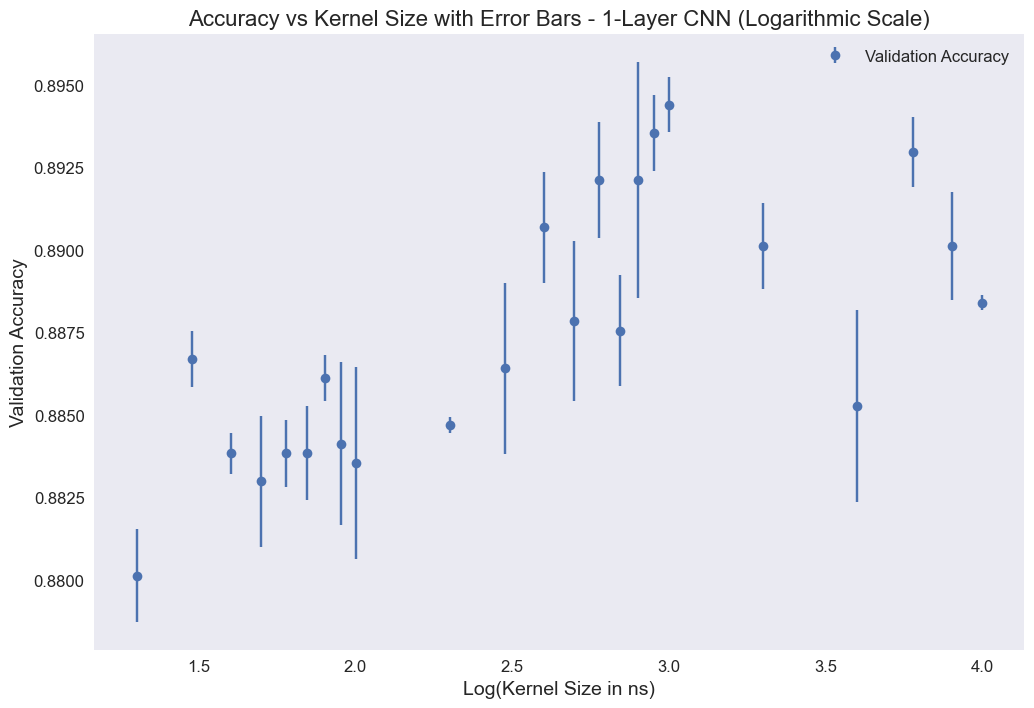

Best kernel size identified: 100 samples (1000 ns)
Training model with kernel size: 1000 samples
Kernel Size (samples): 1000
  Cathode Mean Accuracy: 0.6335
  Tritium Mean Accuracy: 0.9427
  Gate Mean Accuracy: 0.9201
Training model with kernel size: 800 samples
Kernel Size (samples): 800
  Cathode Mean Accuracy: 0.7096
  Tritium Mean Accuracy: 0.9178
  Gate Mean Accuracy: 0.9363
Training model with kernel size: 600 samples
Kernel Size (samples): 600
  Cathode Mean Accuracy: 0.6784
  Tritium Mean Accuracy: 0.9271
  Gate Mean Accuracy: 0.9322
Training model with kernel size: 400 samples
Kernel Size (samples): 400
  Cathode Mean Accuracy: 0.6491
  Tritium Mean Accuracy: 0.9316
  Gate Mean Accuracy: 0.9255
Training model with kernel size: 200 samples
Kernel Size (samples): 200
  Cathode Mean Accuracy: 0.7329
  Tritium Mean Accuracy: 0.9124
  Gate Mean Accuracy: 0.9295
Training model with kernel size: 100 samples
Kernel Size (samples): 100
  Cathode Mean Accuracy: 0.6550
  Tritium Mean Acc

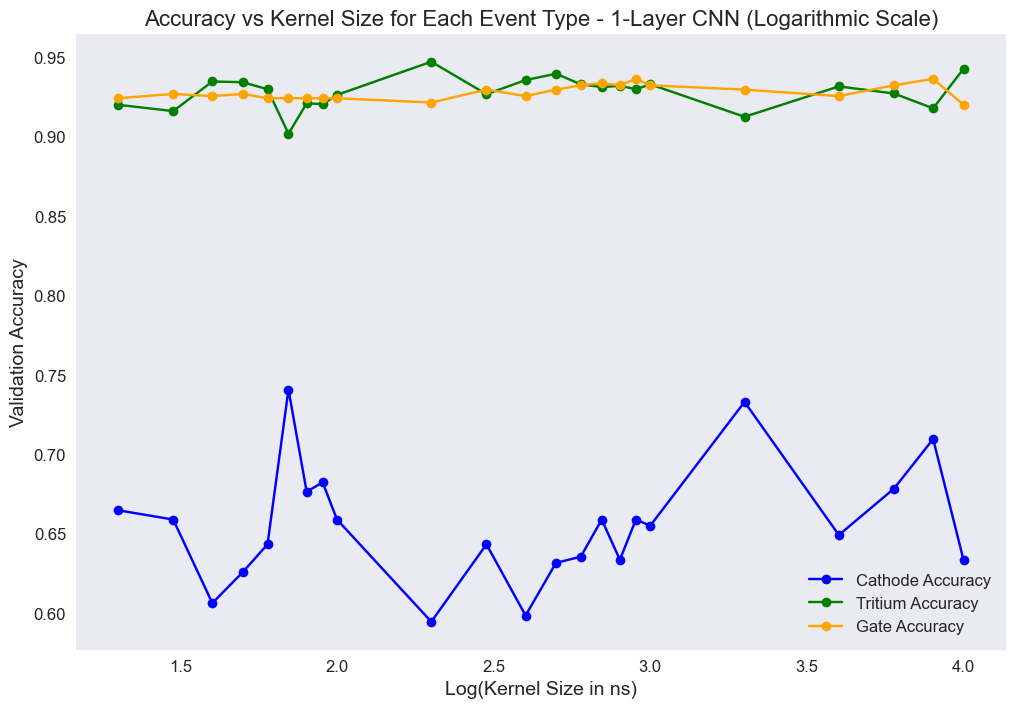

Training model with kernel size: 1000 samples
Kernel Size (samples): 1000
  Training Accuracy: 0.8837
  Test Accuracy: 0.8988
Training model with kernel size: 800 samples
Kernel Size (samples): 800
  Training Accuracy: 0.8839
  Test Accuracy: 0.8947
Training model with kernel size: 600 samples
Kernel Size (samples): 600
  Training Accuracy: 0.8807
  Test Accuracy: 0.8998
Training model with kernel size: 400 samples
Kernel Size (samples): 400
  Training Accuracy: 0.8826
  Test Accuracy: 0.8936
Training model with kernel size: 200 samples
Kernel Size (samples): 200
  Training Accuracy: 0.8841
  Test Accuracy: 0.8962
Training model with kernel size: 100 samples
Kernel Size (samples): 100
  Training Accuracy: 0.8860
  Test Accuracy: 0.8936
Training model with kernel size: 90 samples
Kernel Size (samples): 90
  Training Accuracy: 0.8852
  Test Accuracy: 0.8941
Training model with kernel size: 80 samples
Kernel Size (samples): 80
  Training Accuracy: 0.8837
  Test Accuracy: 0.8900
Training m

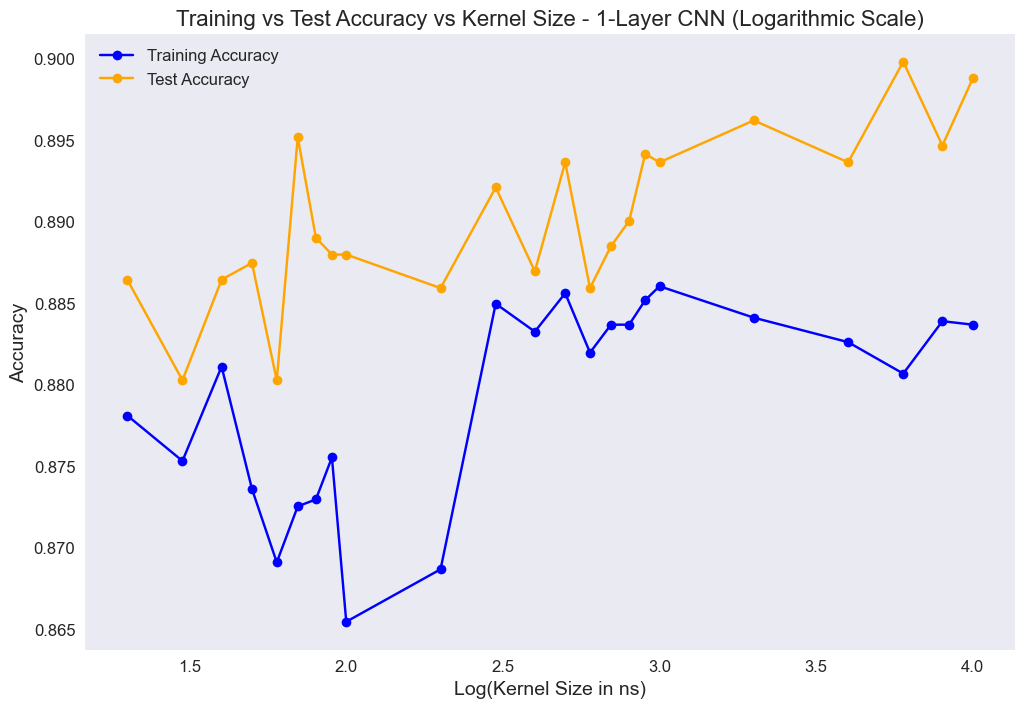

Final model created with best kernel size: 100 samples, 46 filters, and best learning rate: 5.76249e-04


In [ ]:
# Define kernel sizes (combined from all ranges)
kernel_sizes_10us_to_1us = [1000, 800, 600, 400, 200, 100]  # [10 µs, 8 µs, ..., 1 µs]
kernel_sizes_1us_to_100ns = list(range(90, 9, -10))        # [90, 80, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(9, 1, -1))         # [9, 8, ..., 2]
combined_kernel_sizes = kernel_sizes_10us_to_1us + kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Average number of filters between 28 and 64
num_filters = 46  # (28 + 64) / 2 = 46

# Placeholder for accuracies and errors
combined_accuracies = []
combined_errors = []

# Number of runs per kernel size
num_runs = 3

# Run the model multiple times for each kernel size
for kernel_size in combined_kernel_sizes:
    accuracies = []  # Store accuracies for each run
    
    print(f"Training model with kernel size: {kernel_size} samples")
    for _ in range(num_runs): # for statistical reliability
        # Define the 1-layer CNN model with optimal learning rate
        model = Sequential([
            # Single 1D convolution layer with averaged number of filters
            Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=1),
            
            # Dense layers
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model with best learning rate
        optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with weights and get the accuracy
        history = model.fit(
            X_train_padded, 
            y_train, 
            sample_weight=weights_train, 
            epochs=5, 
            batch_size=218, 
            validation_split=0.2, 
            verbose=0
        )
        val_accuracy = history.history['val_accuracy'][-1]
        accuracies.append(val_accuracy)
    
    # Calculate the mean and standard deviation for the kernel size
    mean_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)  # Standard deviation
    sem = std_dev / np.sqrt(num_runs)  # Standard error of the mean
    
    # Store the mean accuracy and error
    combined_accuracies.append(mean_accuracy)
    combined_errors.append(sem)
    
    print(f"Kernel Size (samples): {kernel_size}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {sem:.4f}")

# Convert kernel sizes to nanoseconds for plotting
combined_kernel_sizes_ns = [size * 10 for size in combined_kernel_sizes]  # Convert samples to nanoseconds

# Plot the data with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(combined_kernel_sizes_ns), combined_accuracies, yerr=combined_errors, fmt='o', label='Validation Accuracy', capsize=5)

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size with Error Bars - 1-Layer CNN (Logarithmic Scale)")
plt.legend()
plt.savefig(f'{base_dir}Figures/kernel_size_accuracy_1layer.png', dpi=1800)
plt.show()

# Find the best kernel size from our research
best_kernel_size_index = np.argmax(combined_accuracies)
best_kernel_size = combined_kernel_sizes[best_kernel_size_index]
print(f"Best kernel size identified: {best_kernel_size} samples ({best_kernel_size * 10} ns)")

# Placeholder for accuracies (one list per event type)
cathode_accuracies = []
tritium_accuracies = []
gate_accuracies = []

# Run the model multiple times for each kernel size and record class-specific accuracy
for kernel_size in combined_kernel_sizes:
    cathode_run_accuracies = []  # Store accuracies for cathode
    tritium_run_accuracies = []  # Store accuracies for tritium
    gate_run_accuracies = []     # Store accuracies for gate
    
    print(f"Training model with kernel size: {kernel_size} samples")
    for _ in range(num_runs):
        # Define the 1-layer CNN model with optimal learning rate
        model = Sequential([
            # Single 1D convolution layer with averaged number of filters
            Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=1),
            
            # Dense layers
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model with best learning rate
        optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with weights
        history = model.fit(
            X_train_padded, 
            y_train, 
            sample_weight=weights_train, 
            epochs=5, 
            batch_size=218, 
            validation_split=0.2, 
            verbose=0
        )
        
        # Get predictions for validation set
        val_split = int(0.2 * len(X_train_padded))  # Assuming 20% validation split
        X_val, y_val = X_train_padded[-val_split:], y_train[-val_split:]
        y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
        
        # Calculate accuracies for each event type
        cathode_mask = (y_val == 0)
        tritium_mask = (y_val == 2)
        gate_mask = (y_val == 1)
        
        # Only compute accuracies if there are samples of that class in the validation set
        if np.any(cathode_mask):
            cathode_accuracy = np.mean(y_pred[cathode_mask] == 0)  # True positives for cathode
            cathode_run_accuracies.append(cathode_accuracy)
        
        if np.any(tritium_mask):
            tritium_accuracy = np.mean(y_pred[tritium_mask] == 2)  # True positives for tritium
            tritium_run_accuracies.append(tritium_accuracy)
        
        if np.any(gate_mask):
            gate_accuracy = np.mean(y_pred[gate_mask] == 1)     # True positives for gate
            gate_run_accuracies.append(gate_accuracy)
    
    # Calculate mean accuracy across runs
    if cathode_run_accuracies:
        cathode_accuracies.append(np.mean(cathode_run_accuracies))
    else:
        cathode_accuracies.append(np.nan)
        
    if tritium_run_accuracies:
        tritium_accuracies.append(np.mean(tritium_run_accuracies))
    else:
        tritium_accuracies.append(np.nan)
        
    if gate_run_accuracies:
        gate_accuracies.append(np.mean(gate_run_accuracies))
    else:
        gate_accuracies.append(np.nan)
    
    print(f"Kernel Size (samples): {kernel_size}")
    print(f"  Cathode Mean Accuracy: {cathode_accuracies[-1]:.4f}")
    print(f"  Tritium Mean Accuracy: {tritium_accuracies[-1]:.4f}")
    print(f"  Gate Mean Accuracy: {gate_accuracies[-1]:.4f}")

# Plot the data for each class
plt.figure(figsize=(12, 8))
plt.plot(np.log10(combined_kernel_sizes_ns), cathode_accuracies, marker='o', label='Cathode Accuracy', color='blue')
plt.plot(np.log10(combined_kernel_sizes_ns), tritium_accuracies, marker='o', label='Tritium Accuracy', color='green')
plt.plot(np.log10(combined_kernel_sizes_ns), gate_accuracies, marker='o', label='Gate Accuracy', color='orange')

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Kernel Size for Each Event Type - 1-Layer CNN (Logarithmic Scale)")
plt.legend()
plt.savefig(f'{base_dir}Figures/kernel_size_by_class_1layer.png', dpi=1800)
plt.show()

# Placeholder for accuracies
training_accuracies = []
test_accuracies = []

# Run the model for each kernel size and compare training vs test accuracy
for kernel_size in combined_kernel_sizes:
    print(f"Training model with kernel size: {kernel_size} samples")
    
    # Define the 1-layer CNN model with optimal learning rate
    model = Sequential([
        # Single 1D convolution layer with averaged number of filters
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=1),
        
        # Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model with best learning rate
    optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model with weights
    history = model.fit(
        X_train_padded, 
        y_train, 
        sample_weight=weights_train, 
        epochs=5, 
        batch_size=218, 
        validation_split=0.2, 
        verbose=0
    )
    
    # Record training accuracy (last epoch)
    training_accuracy = history.history['accuracy'][-1]
    training_accuracies.append(training_accuracy)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    test_accuracies.append(test_accuracy)
    
    print(f"Kernel Size (samples): {kernel_size}")
    print(f"  Training Accuracy: {training_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

# Plot training vs test accuracy
plt.figure(figsize=(12, 8))
plt.plot(np.log10(combined_kernel_sizes_ns), training_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(np.log10(combined_kernel_sizes_ns), test_accuracies, marker='o', label='Test Accuracy', color='orange')

# Add labels and title
plt.xlabel("Log(Kernel Size in ns)")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy vs Kernel Size - 1-Layer CNN (Logarithmic Scale)")
plt.legend()
plt.savefig(f'{base_dir}Figures/training_vs_test_1layer.png', dpi=1800)
plt.show()

# Build final model with best kernel size and learning rate
final_model = Sequential([
    # Single 1D convolution layer with averaged number of filters
    Conv1D(filters=num_filters, kernel_size=best_kernel_size, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
    MaxPooling1D(pool_size=1),
    
    # Dense layers
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the final model with best learning rate
optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"Final model created with best kernel size: {best_kernel_size} samples, {num_filters} filters, and best learning rate: {best_lr:.5e}")

## Conv2 Layer Kernel Size Optimisation

Using first layer kernel size: 100 samples (1000 ns)
First layer filters: 46, Second layer filters: 92
Stride: 1, Pool size: 1
Training model with second layer kernel size: 90 samples
Layer 2 Kernel Size (samples): 90, Mean Accuracy: 0.8884, SEM: 0.0022
Training model with second layer kernel size: 80 samples
Layer 2 Kernel Size (samples): 80, Mean Accuracy: 0.8873, SEM: 0.0037
Training model with second layer kernel size: 70 samples
Layer 2 Kernel Size (samples): 70, Mean Accuracy: 0.8813, SEM: 0.0041
Training model with second layer kernel size: 60 samples
Layer 2 Kernel Size (samples): 60, Mean Accuracy: 0.8941, SEM: 0.0006
Training model with second layer kernel size: 50 samples
Layer 2 Kernel Size (samples): 50, Mean Accuracy: 0.8864, SEM: 0.0030
Training model with second layer kernel size: 40 samples
Layer 2 Kernel Size (samples): 40, Mean Accuracy: 0.8901, SEM: 0.0014
Training model with second layer kernel size: 30 samples
Layer 2 Kernel Size (samples): 30, Mean Accuracy: 0.89

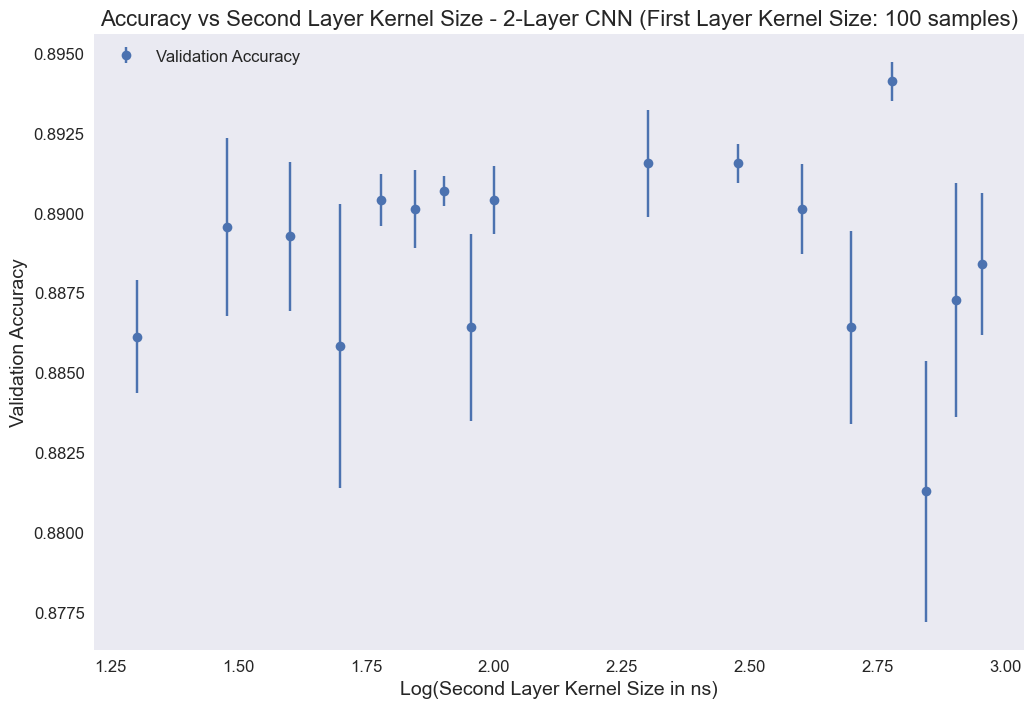

Best second layer kernel size identified: 60 samples (600 ns)
Best validation accuracy: 0.8941

Final Two-Layer Model Architecture:
Model: "sequential_390"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_534 (Conv1D)         (None, 2828, 46)          4646      
                                                                 
 max_pooling1d_530 (MaxPool  (None, 2828, 46)          0         
 ing1D)                                                          
                                                                 
 conv1d_535 (Conv1D)         (None, 2828, 92)          254012    
                                                                 
 max_pooling1d_531 (MaxPool  (None, 2828, 92)          0         
 ing1D)                                                          
                                                                 
 flatten_390 (Flatten)       (None, 260176)         

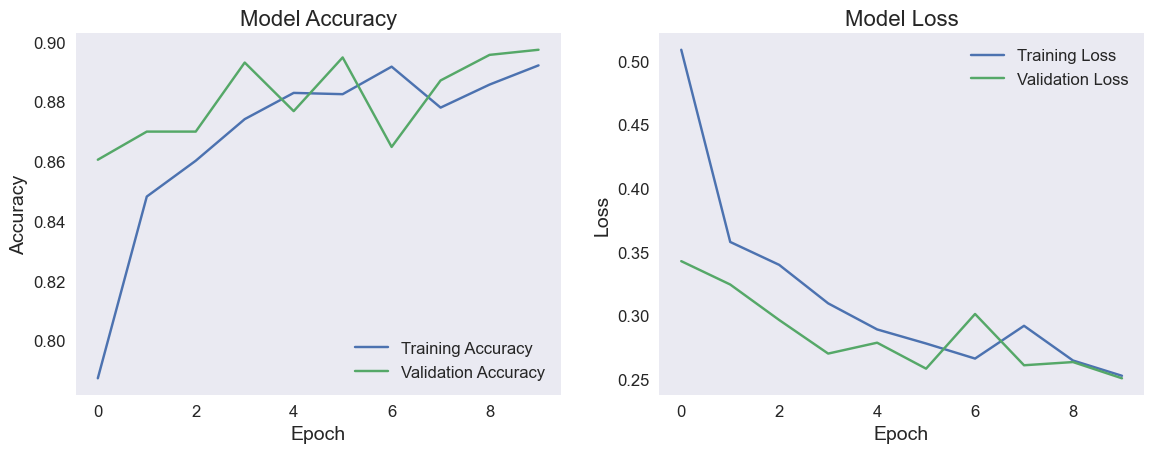


Best parameters for two-layer CNN:
Layer 1 Kernel Size: 100 samples (1000 ns)
Layer 2 Kernel Size: 60 samples (600 ns)
Layer 1 Filters: 46
Layer 2 Filters: 92
Stride: 1
Pool Size: 1
Learning Rate: 5.76249e-04
Batch Size: 323


In [ ]:
# Now let's optimize the kernel size for the second layer while using the best kernel size for the first layer

# Define kernel sizes for second layer (smaller kernels this time as we have reduced dimensionality from conv1 operation)
kernel_sizes_1us_to_100ns = list(range(90, 9, -10))        # [90, 80, ..., 10]
kernel_sizes_100ns_to_20ns = list(range(9, 1, -1))         # [9, 8, ..., 2]
combined_kernel_sizes_layer2 = kernel_sizes_1us_to_100ns + kernel_sizes_100ns_to_20ns

# Use best kernel size for first layer
first_layer_kernel_size = best_kernel_size

# # Use the best number of filters from previous optimizations
# filters_layer1 = best_filters_conv1 if 'best_filters_conv1' in locals() else num_filters
# filters_layer2 = best_filters_conv2 if 'best_filters_conv2' in locals() else num_filters

# # Use best stride and pool size if available from Bayesian optimization
# stride = best_stride if 'best_stride' in locals() else 1
# pool_size = best_pool_size if 'best_pool_size' in locals() else 1

# Placeholder for accuracies and errors
layer2_accuracies = []
layer2_errors = []

# Number of runs per kernel size
num_runs = 3

print(f"Using first layer kernel size: {first_layer_kernel_size} samples ({first_layer_kernel_size * 10} ns)")
print(f"First layer filters: {num_filters}, Second layer filters: {2*num_filters}")
print(f"Stride: 1, Pool size: 1")

# Run the model multiple times for each second layer kernel size
for kernel_size_layer2 in combined_kernel_sizes_layer2:
    accuracies = []  # Store accuracies for each run
    
    print(f"Training model with second layer kernel size: {kernel_size_layer2} samples")
    
    for _ in range(num_runs): # for statistical reliability
        # Define the 2-layer CNN model
        model = Sequential([
            # First convolutional layer with best kernel size
            Conv1D(filters=num_filters, 
                   kernel_size=first_layer_kernel_size,
                   padding='same',
                   activation='relu', 
                   input_shape=(X_train_padded.shape[1], 1)),
            MaxPooling1D(pool_size=1),
            
            # Second convolutional layer with varying kernel size
            Conv1D(filters=2*num_filters,
                   kernel_size=kernel_size_layer2,
                   padding='same',
                   activation='relu'),
            MaxPooling1D(pool_size=1),
            
            # Dense layers
            Flatten(),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
        
        # Compile the model with best learning rate
        optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        try:
            # Train the model with weights and get the accuracy
            history = model.fit(
                X_train_padded, 
                y_train, 
                sample_weight=weights_train, 
                epochs=5, 
                batch_size=best_batch_size if 'best_batch_size' in locals() else 218, 
                validation_split=0.2, 
                verbose=0
            )
            val_accuracy = history.history['val_accuracy'][-1]
            accuracies.append(val_accuracy)
            
        except Exception as e:
            print(f"Error with kernel size {kernel_size_layer2}: {e}")
            # Skip this kernel size if error occurs
            continue
    
    # Only calculate stats if we have results
    if accuracies:
        # Calculate the mean and standard deviation for the kernel size
        mean_accuracy = np.mean(accuracies)
        std_dev = np.std(accuracies)  # Standard deviation
        sem = std_dev / np.sqrt(len(accuracies))  # Standard error of the mean
        
        # Store the mean accuracy and error
        layer2_accuracies.append(mean_accuracy)
        layer2_errors.append(sem)
        
        print(f"Layer 2 Kernel Size (samples): {kernel_size_layer2}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {sem:.4f}")
    else:
        # Skip this kernel size in our results
        print(f"Skipping kernel size {kernel_size_layer2} due to errors")

# Only keep the kernel sizes that had valid accuracies
valid_kernel_sizes = [size for i, size in enumerate(combined_kernel_sizes_layer2) if i < len(layer2_accuracies)]
valid_kernel_sizes_ns = [size * 10 for size in valid_kernel_sizes]  # Convert to nanoseconds

# Plot the data with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(valid_kernel_sizes_ns), layer2_accuracies, yerr=layer2_errors, fmt='o', label='Validation Accuracy', capsize=5)

# Add labels and title
plt.xlabel("Log(Second Layer Kernel Size in ns)")
plt.ylabel("Validation Accuracy")
plt.title(f"Accuracy vs Second Layer Kernel Size - 2-Layer CNN (First Layer Kernel Size: {first_layer_kernel_size} samples)")
plt.legend()
plt.savefig(f'{base_dir}Figures/layer2_kernel_size_accuracy.png', dpi=1800)
plt.show()

# Find the best kernel size for layer 2
if layer2_accuracies:
    best_kernel_size_layer2_index = np.argmax(layer2_accuracies)
    best_kernel_size_layer2 = valid_kernel_sizes[best_kernel_size_layer2_index]
    best_accuracy = layer2_accuracies[best_kernel_size_layer2_index]
    print(f"Best second layer kernel size identified: {best_kernel_size_layer2} samples ({best_kernel_size_layer2 * 10} ns)")
    print(f"Best validation accuracy: {best_accuracy:.4f}")

    # Now test both layers with their best kernel sizes on the test set
    final_two_layer_model = Sequential([
        # First convolutional layer with best kernel size
        Conv1D(filters=num_filters, 
               kernel_size=first_layer_kernel_size, 
               strides=1, 
               padding='same',
               activation='relu', 
               input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=1),
        
        # Second convolutional layer with best kernel size
        Conv1D(filters=2*num_filters,
               kernel_size=best_kernel_size_layer2,
               strides=1,
               padding='same',
               activation='relu'),
        MaxPooling1D(pool_size=1),
        
        # Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the final model with best learning rate
    optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
    final_two_layer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Print model summary
    print("\nFinal Two-Layer Model Architecture:")
    final_two_layer_model.summary()
    
    # Train the final model
    final_history = final_two_layer_model.fit(
        X_train_padded, 
        y_train, 
        sample_weight=weights_train, 
        epochs=10,  # More epochs for final model
        batch_size=best_batch_size if 'best_batch_size' in locals() else 218, 
        validation_split=0.2, 
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_accuracy = final_two_layer_model.evaluate(X_test_padded, y_test, verbose=1)
    print(f"\nFinal Two-Layer Model Test Accuracy: {test_accuracy:.4f}")
    
    # Get predictions for detailed metrics
    y_pred = np.argmax(final_two_layer_model.predict(X_test_padded), axis=1)
    
    # Calculate class-specific accuracies
    for class_id in range(3):
        class_mask = (y_test == class_id)
        if np.any(class_mask):
            class_accuracy = np.mean(y_pred[class_mask] == class_id)
            class_name = ["Cathode", "Gate", "Tritium"][class_id]
            print(f"{class_name} Test Accuracy: {class_accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(final_history.history['accuracy'], label='Training Accuracy')
    plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(final_history.history['loss'], label='Training Loss')
    plt.plot(final_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{base_dir}Figures/final_two_layer_model_history.png', dpi=1800)
    plt.show()
    
    # Save the best kernel sizes and related parameters
    print(f"\nBest parameters for two-layer CNN:")
    print(f"Layer 1 Kernel Size: {first_layer_kernel_size} samples ({first_layer_kernel_size * 10} ns)")
    print(f"Layer 2 Kernel Size: {best_kernel_size_layer2} samples ({best_kernel_size_layer2 * 10} ns)")
    print(f"Layer 1 Filters: {num_filters}")
    print(f"Layer 2 Filters: {2*num_filters}")
    print(f"Stride: {1}")
    print(f"Pool Size: {1}")
    print(f"Learning Rate: {best_lr:.5e}")
    print(f"Batch Size: {best_batch_size if 'best_batch_size' in locals() else 218}")
else:
    print("No valid kernel sizes found for layer 2. Please adjust the range of kernel sizes or other parameters.")

## Batch Size, Stride, $N_{filters}$, Pool Size Optimisation via Random (Grid) Search

Testing: Batch Size=218, Stride=20, Filters=64, Pool Size=2
Test Accuracy: 0.8895
Testing: Batch Size=32, Stride=10, Filters=64, Pool Size=2
Test Accuracy: 0.8890
Testing: Batch Size=64, Stride=20, Filters=64, Pool Size=5
Test Accuracy: 0.8895
Testing: Batch Size=218, Stride=10, Filters=32, Pool Size=4
Test Accuracy: 0.8911
Testing: Batch Size=16, Stride=10, Filters=32, Pool Size=4
Test Accuracy: 0.8890
Testing: Batch Size=64, Stride=10, Filters=64, Pool Size=2
Test Accuracy: 0.8885
Testing: Batch Size=64, Stride=20, Filters=128, Pool Size=4
Test Accuracy: 0.8977
Testing: Batch Size=32, Stride=2, Filters=128, Pool Size=5
Test Accuracy: 0.8869
Testing: Batch Size=32, Stride=10, Filters=64, Pool Size=5
Test Accuracy: 0.8834
Testing: Batch Size=64, Stride=3, Filters=32, Pool Size=5
Test Accuracy: 0.9003
Testing: Batch Size=64, Stride=5, Filters=128, Pool Size=5
Test Accuracy: 0.8880
Testing: Batch Size=218, Stride=20, Filters=32, Pool Size=2
Test Accuracy: 0.8983
Testing: Batch Size=64, S

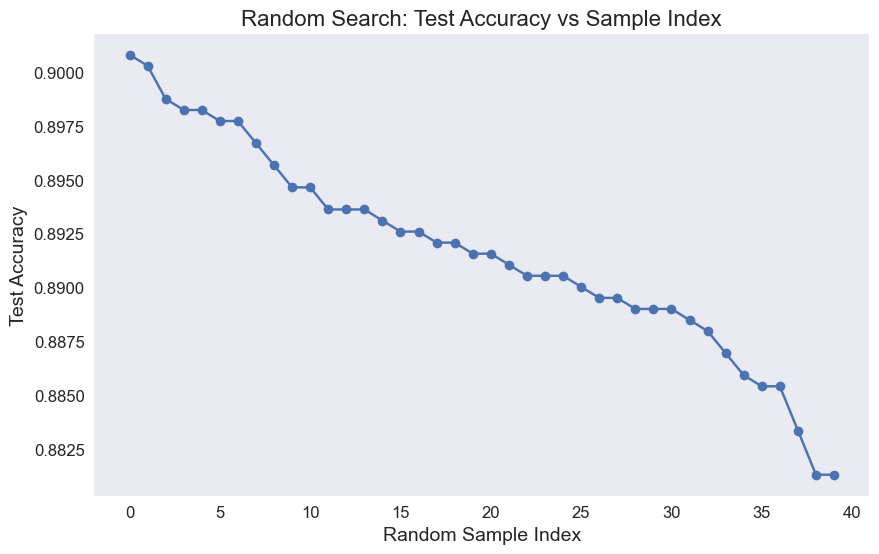

In [ ]:
# Random Search Optimisation
# Define ranges for hyperparameters
batch_size_range = [16, 32, 64, 218]
stride_range = [1, 2, 3, 5, 10, 20]
num_filters_range = [16, 32, 64, 128]
pool_size_range = [2, 3, 4, 5]

# Number of random samples to try
num_samples = 40

# Store results
random_search_results = []

for _ in range(num_samples):
    # Randomly sample hyperparameters
    batch_size = random.choice(batch_size_range)
    stride = random.choice(stride_range)
    filters = random.choice(num_filters_range)
    pool_size = random.choice(pool_size_range)
    
    print(f"Testing: Batch Size={batch_size}, Stride={stride}, Filters={filters}, Pool Size={pool_size}")
    
    # Define the model
    model = Sequential([
        Conv1D(filters=filters, kernel_size=best_kernel_size, strides=stride, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=pool_size),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model with the best learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_padded, y_train, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    
    # Append results
    random_search_results.append({
        'batch_size': batch_size,
        'stride': stride,
        'filters': filters,
        'pool_size': pool_size,
        'accuracy': test_accuracy
    })
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Sort results by accuracy
random_search_results = sorted(random_search_results, key=lambda x: x['accuracy'], reverse=True)

# Display top-performing hyperparameter combinations
print("\nTop 5 hyperparameter combinations from Random Search:")
for i, result in enumerate(random_search_results[:5]):
    print(f"{i+1}. Batch Size={result['batch_size']}, Stride={result['stride']}, Filters={result['filters']}, Pool Size={result['pool_size']}, Accuracy={result['accuracy']:.4f}")

# Visualize the accuracy of random samples
accuracies = [res['accuracy'] for res in random_search_results]
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.xlabel("Random Sample Index")
plt.ylabel("Test Accuracy")
plt.title("Random Search: Test Accuracy vs Sample Index")
plt.savefig(f'{base_dir}Figures/random_search_results.png', dpi=1800)
plt.show()

## Batch Size, Stride, $N_{filters}$, Pool Size Optimisation via Bayesian Optimisation (Gaussian Processes)

More Complex and Nuanced Analysis Compared to Grid Search in the Sense that we are now Splitting $N_{filters}$ into 2 separate Hparams for each conv layer.

Testing: Batch Size=411, Stride=3, Filters Conv1=106, Filters Conv2=179, Pool Size=2, Kernel Size=100
Test Accuracy: 0.8849
Testing: Batch Size=66, Stride=5, Filters Conv1=61, Filters Conv2=91, Pool Size=2, Kernel Size=100
Test Accuracy: 0.8931
Testing: Batch Size=44, Stride=7, Filters Conv1=122, Filters Conv2=64, Pool Size=3, Kernel Size=100
Test Accuracy: 0.8885
Testing: Batch Size=322, Stride=7, Filters Conv1=29, Filters Conv2=68, Pool Size=2, Kernel Size=100
Test Accuracy: 0.8952
Testing: Batch Size=214, Stride=1, Filters Conv1=125, Filters Conv2=109, Pool Size=1, Kernel Size=100
Test Accuracy: 0.8772
Testing: Batch Size=323, Stride=4, Filters Conv1=126, Filters Conv2=154, Pool Size=3, Kernel Size=100
Test Accuracy: 0.9034
Testing: Batch Size=353, Stride=5, Filters Conv1=29, Filters Conv2=245, Pool Size=2, Kernel Size=100
Test Accuracy: 0.8952
Testing: Batch Size=207, Stride=1, Filters Conv1=51, Filters Conv2=110, Pool Size=2, Kernel Size=100
Test Accuracy: 0.8977
Testing: Batch Si

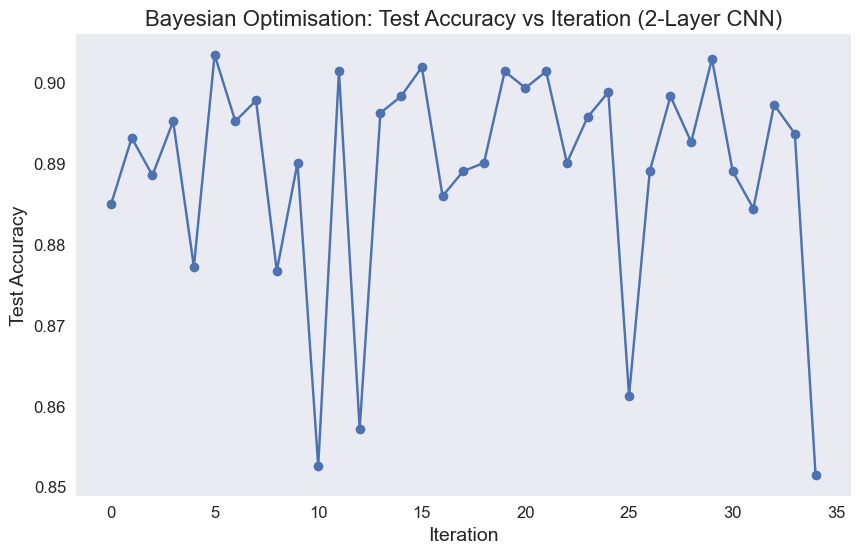

Using best parameters - Learning Rate: 5.76249e-04, Batch Size: 323, Stride: 4, Filters Conv1: 126, Filters Conv2: 154, Pool Size: 3, Kernel Size: 100 samples


ValueError: The `strides` argument must be a tuple of 1 integers. Received: 4

In [ ]:
# Define hyperparameter space with separate filter counts for each conv layer
space = [
    Integer(16, 512, name='batch_size'),                         # Batch size
    Integer(1, 10, name='stride'),                               # Stride (reduced max value)
    Integer(28, 128, name='filters_conv1'),                      # Number of filters in first conv layer
    Integer(64, 256, name='filters_conv2'),                      # Number of filters in second conv layer
    Integer(1, 3, name='pool_size')                              # Pool size (reduced max value)
]

# Function to evaluate model performance with given hyperparameters
@use_named_args(space)
def objective(batch_size, stride, filters_conv1, filters_conv2, pool_size):
    print(f"Testing: Batch Size={batch_size}, Stride={stride}, Filters Conv1={filters_conv1}, " + 
          f"Filters Conv2={filters_conv2}, Pool Size={pool_size}, Kernel Size={best_kernel_size}")
    
    # Define the 2-layer model with padding='same' to avoid dimension issues
    model = Sequential([
        # First convolutional layer
        Conv1D(filters=filters_conv1, 
               kernel_size=best_kernel_size, 
               strides=(stride,), 
               activation='relu',
               padding='same',  # Add padding to maintain dimensions
               input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=(pool_size,)),
        
        # Second convolutional layer
        Conv1D(filters=filters_conv2,
               kernel_size=best_kernel_size,
               strides=(stride,),
               padding='same',  # Add padding to maintain dimensions
               activation='relu'),
        MaxPooling1D(pool_size=(pool_size,)),
        
        # Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model with the best learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Try/except block to catch dimension errors
    try:
        # Train the model
        model.fit(
            X_train_padded, 
            y_train, 
            sample_weight=weights_train,  # Include sample weights
            epochs=5, 
            batch_size=batch_size, 
            validation_split=0.2, 
            verbose=0
        )
        
        # Evaluate the model
        _, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Minimise negative accuracy (maximise accuracy)
        return -test_accuracy
    
    except Exception as e:
        print(f"Error during training: {e}")
        # Return a very poor score to avoid these parameters in future iterations
        return 0.0

# Run Bayesian optimisation
results = gp_minimize(objective, space, n_calls=35, random_state=42)

# Extract the best result
best_hyperparams = results.x
best_score = -results.fun

print("\nBest Hyperparameters from Bayesian Optimization:")
print(f"Batch Size: {best_hyperparams[0]}")
print(f"Stride: {best_hyperparams[1]}")
print(f"Filters Conv1: {best_hyperparams[2]}")
print(f"Filters Conv2: {best_hyperparams[3]}")
print(f"Pool Size: {best_hyperparams[4]}")
print(f"Best Test Accuracy: {best_score:.4f}")

# Visualize the convergence of Bayesian optimisation
plt.figure(figsize=(10, 6))
plt.plot(-np.array(results.func_vals), marker='o')
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.title("Bayesian Optimisation: Test Accuracy vs Iteration (2-Layer CNN)")
plt.savefig(f'{base_dir}Figures/bayesian_optimization_2layer.png', dpi=1800)
plt.show()

# Use the best parameters from optimization
best_batch_size = best_hyperparams[0]
best_stride = best_hyperparams[1]
best_filters_conv1 = best_hyperparams[2]
best_filters_conv2 = best_hyperparams[3]
best_pool_size = best_hyperparams[4

In [ ]:
print(f"Using best parameters - Learning Rate: {best_lr:.5e}, Batch Size: {best_batch_size}, Stride: {best_stride}, " +
      f"Filters Conv1: {best_filters_conv1}, Filters Conv2: {best_filters_conv2}, " +
      f"Pool Size: {best_pool_size}, Kernel Size: {best_kernel_size} samples")

# Build the final model with optimal hyperparameters
final_model = Sequential([
    # First convolutional layer
    Conv1D(filters=best_filters_conv1, 
           kernel_size=best_kernel_size, 
           strides=(best_stride,), 
           padding='same',  # Add padding to maintain dimensions
           activation='relu', 
           input_shape=(X_train_padded.shape[1], 1)),
    MaxPooling1D(pool_size=(best_pool_size,)),
    
    # Second convolutional layer
    Conv1D(filters=best_filters_conv2,
           kernel_size=best_kernel_size,
           strides=(best_stride,),
           padding='same',  # Add padding to maintain dimensions 
           activation='relu'),
    MaxPooling1D(pool_size=(best_pool_size,)),
    
    # Dense layers
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile with optimal parameters
optimizer = keras.optimizers.legacy.Adam(learning_rate=best_lr)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print("\nFinal Model Architecture:")
final_model.summary()

Using best parameters - Learning Rate: 5.76249e-04, Batch Size: 323, Stride: 4, Filters Conv1: 126, Filters Conv2: 154, Pool Size: 3, Kernel Size: 100 samples

Final Model Architecture:
Model: "sequential_336"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_425 (Conv1D)         (None, 707, 126)          12726     
                                                                 
 max_pooling1d_422 (MaxPool  (None, 235, 126)          0         
 ing1D)                                                          
                                                                 
 conv1d_426 (Conv1D)         (None, 59, 154)           1940554   
                                                                 
 max_pooling1d_423 (MaxPool  (None, 19, 154)           0         
 ing1D)                                                          
                                                                

## Trimming Research

Trimming 0 values from the front
Front Trim: 0, Test Accuracy: 0.8988
Trimming 50 values from the front
Front Trim: 50, Test Accuracy: 0.8931
Trimming 100 values from the front
Front Trim: 100, Test Accuracy: 0.8921
Trimming 150 values from the front
Front Trim: 150, Test Accuracy: 0.8880
Trimming 200 values from the front
Front Trim: 200, Test Accuracy: 0.8905
Trimming 250 values from the front
Front Trim: 250, Test Accuracy: 0.8941
Trimming 300 values from the front
Front Trim: 300, Test Accuracy: 0.8962
Trimming 350 values from the front
Front Trim: 350, Test Accuracy: 0.8895
Trimming 400 values from the front
Front Trim: 400, Test Accuracy: 0.8967
Trimming 450 values from the front
Front Trim: 450, Test Accuracy: 0.8952
Trimming 500 values from the front
Front Trim: 500, Test Accuracy: 0.8936
Trimming 550 values from the front
Front Trim: 550, Test Accuracy: 0.8931
Trimming 600 values from the front
Front Trim: 600, Test Accuracy: 0.8844
Trimming 650 values from the front
Front Tri

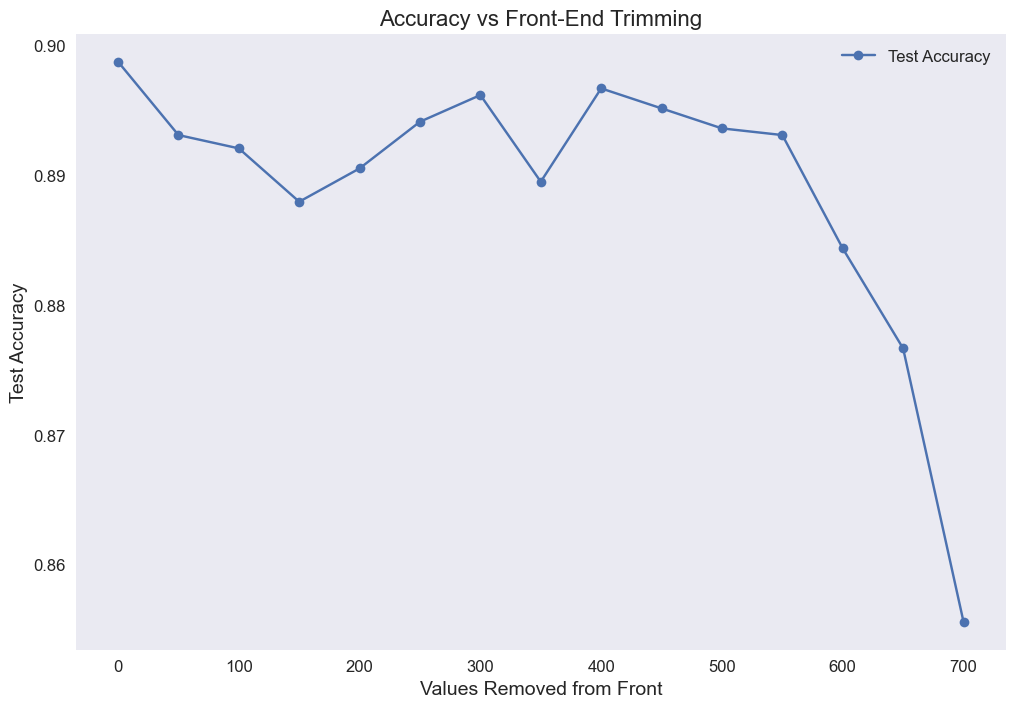

Trimming 0 values from the back
Back Trim: 0, Test Accuracy: 0.8962
Trimming 50 values from the back
Back Trim: 50, Test Accuracy: 0.8936
Trimming 100 values from the back
Back Trim: 100, Test Accuracy: 0.8839
Trimming 150 values from the back
Back Trim: 150, Test Accuracy: 0.8957
Trimming 200 values from the back
Back Trim: 200, Test Accuracy: 0.8962
Trimming 250 values from the back
Back Trim: 250, Test Accuracy: 0.8967
Trimming 300 values from the back
Back Trim: 300, Test Accuracy: 0.8936
Trimming 350 values from the back
Back Trim: 350, Test Accuracy: 0.8931
Trimming 400 values from the back
Back Trim: 400, Test Accuracy: 0.8977
Trimming 450 values from the back
Back Trim: 450, Test Accuracy: 0.9003
Trimming 500 values from the back
Back Trim: 500, Test Accuracy: 0.8936
Trimming 550 values from the back
Back Trim: 550, Test Accuracy: 0.8905
Trimming 600 values from the back
Back Trim: 600, Test Accuracy: 0.8962
Trimming 650 values from the back
Back Trim: 650, Test Accuracy: 0.893

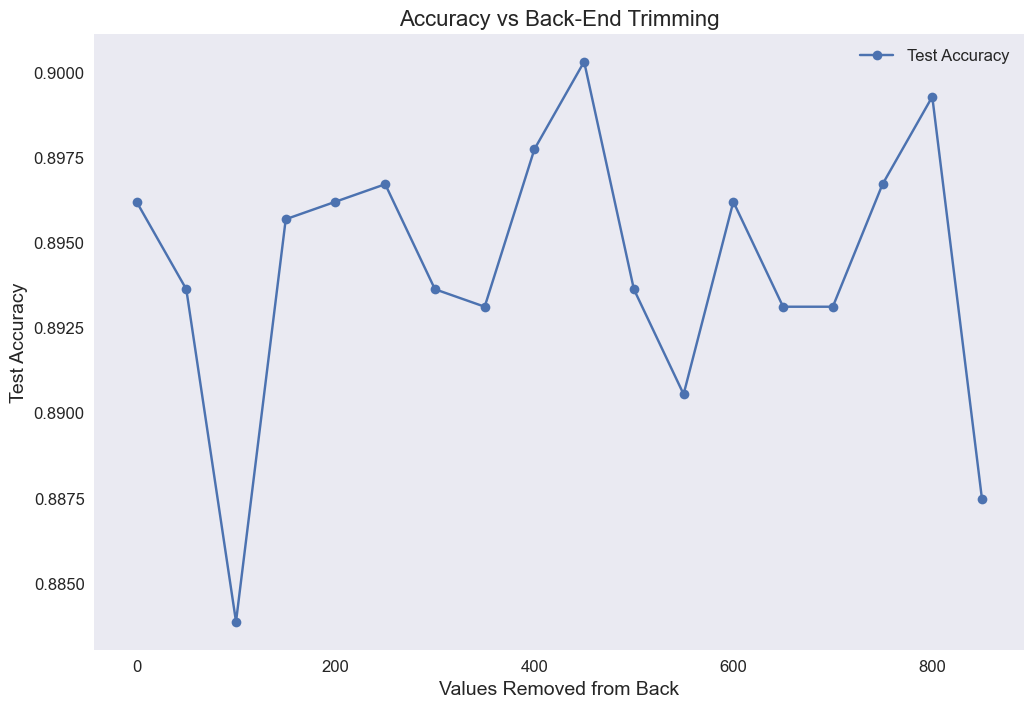

In [ ]:
# Placeholder for accuracies
front_trim_accuracies = []
front_trims = []

# Loop to incrementally remove values from the front
for front_trim in range(0, X_train_padded.shape[1], 50):  # Remove in steps of 50 timesteps = 500 ns = 0.5 µs
    print(f"Trimming {front_trim} values from the front")
    
    # Trim the front of the waveform
    X_train_trimmed = X_train_padded[:, front_trim:]
    X_test_trimmed = X_test_padded[:, front_trim:]
    
    # Define the CNN model with best parameters
    model = Sequential([
        Conv1D(filters=best_filters_conv2, kernel_size=best_kernel_size, strides=(best_stride,), activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=(best_pool_size,)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model with best batch size
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=best_batch_size, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    front_trim_accuracies.append(test_accuracy)
    front_trims.append(front_trim)
    
    print(f"Front Trim: {front_trim}, Test Accuracy: {test_accuracy:.4f}")
    
    # Stop if accuracy decreases by more than 0.01
    if len(front_trim_accuracies) > 1 and (front_trim_accuracies[-1] < front_trim_accuracies[-2] - 0.01):
        print("Accuracy decreased by more than 0.01. Stopping.")
        break


print(f'Best Front Trim Value: {front_trims[np.argmax(front_trim_accuracies)] * 10} ns')
print(f'Best Front Trim Accuracy: {max(front_trim_accuracies):.4f}')


# Plot front trim results
plt.figure(figsize=(12, 8))
plt.plot((range(0, len(front_trim_accuracies) * 50, 50))/100, front_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Front ")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Front-End Trimming")
plt.legend()
plt.savefig(f'{base_dir}Figures/front_trim.png', dpi=1800)
plt.show()

# Placeholder for accuracies
back_trim_accuracies = []

# Loop to incrementally remove values from the back
for back_trim in range(0, X_train_padded.shape[1], 50):  # Remove in steps of 50
    print(f"Trimming {back_trim} values from the back")
    
    # Trim the back of the waveforms
    X_train_trimmed = X_train_padded[:, :-back_trim] if back_trim > 0 else X_train_padded
    X_test_trimmed = X_test_padded[:, :-back_trim] if back_trim > 0 else X_test_padded
    
    # Define the CNN model
    model = Sequential([
        Conv1D(filters=best_filters_conv2, kernel_size=best_kernel_size, strides=(best_stride,), activation='relu', input_shape=(X_train_trimmed.shape[1], 1)),
        MaxPooling1D(pool_size=(best_pool_size,)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_trimmed, y_train, epochs=5, batch_size=best_batch_size, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test_trimmed, y_test, verbose=0)
    back_trim_accuracies.append(test_accuracy)
    
    print(f"Back Trim: {back_trim}, Test Accuracy: {test_accuracy:.4f}")
    
    # Stop if accuracy starts decreasing
    if len(back_trim_accuracies) > 1 and test_accuracy < back_trim_accuracies[-2] - 0.01:
        print("Accuracy decreased by more than 0.01. Stopping.")
        break

# Plot back trim results
plt.figure(figsize=(12, 8))
plt.plot(range(0, len(back_trim_accuracies) * 50, 50), back_trim_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Values Removed from Back")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Back-End Trimming")
plt.legend()
plt.savefig(f'{base_dir}Figures/back_trim.png', dpi=1800)
plt.show()